# Data Science: Performance of Pure Python vs Pandas vs Numpy

## Intro
In this notebook wie will compare data processing speed of pure Python, Pandas and Numpy

## Imports

In [1]:
# Python 3.6
import os
import sys
import gc
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare dummy random dataset

In [2]:
# clear memory
gc.collect()
# We will prepare artificial dataset that contains orders of the product.
# Each order will have random number of items ordered and random price within given range
dataset_python = []
products_ids = [1,10000] # number of products in the dataset
range_orders = [1,10] # range of orders for product from which to select one random value
range_quantity = [1,100] # range of quantity in order from which to select one random value
range_price = [0.1,30.00] # range of product prices from which to select one random value

In [3]:
def generate_dummy_dataset(products_ids,range_orders,products_quantity,products_price):
    generated_dataset = []
    for idx in range(products_ids[0],products_ids[1]):
        random_orders = random.randint(range_orders[0],range_orders[1]) 
        for odx in range(random_orders):
            quantity = random.randint(range_quantity[0],range_quantity[1])
            price = random.uniform(range_price[0],range_price[1])
            generated_dataset.append([idx,odx,quantity,price])
    return generated_dataset

In [4]:
dataset_python = generate_dummy_dataset(products_ids,range_orders,range_quantity,range_price)
print ("Dataset size",len(dataset_python),"records")
dataset_python[0:3]

Dataset size 55136 records


[[1, 0, 47, 5.072906551868127],
 [1, 1, 22, 23.90221557817653],
 [1, 2, 17, 18.496793608855274]]

In [5]:
dataset_numpy = np.array(dataset_python)
dataset_numpy[0:3,:]

array([[  1.        ,   0.        ,  47.        ,   5.07290655],
       [  1.        ,   1.        ,  22.        ,  23.90221558],
       [  1.        ,   2.        ,  17.        ,  18.49679361]])

In [6]:
dataset_pandas = pd.DataFrame(data=dataset_numpy,columns=['product_id','product_order_num','quantity','price'])
dataset_pandas.head(3)

,product_id,product_order_num,quantity,price
0,1.0,0.0,47.0,5.072907
1,1.0,1.0,22.0,23.902216
2,1.0,2.0,17.0,18.496794


## Pure Python function

In [7]:
# function generating statistics using pure Python
def gen_stats_python(dataset_python):
    start = time.time()
    product_stats = []
    unique_products = set([x[0] for x in dataset_python])
    for product_id in unique_products:
        product_items = [x for x in dataset_python if x[0]==product_id ]
        num_orders = len(product_items)
        total_quantity = 0
        total_price = 0
        for row in product_items:
            total_quantity += row[2]
            total_price += row[3]
        avg_price = float(total_price/num_orders)
        product_stats.append([int(product_id),int(num_orders),int(total_quantity),round(avg_price,2)])
    end = time.time()
    working_time = end-start
    return product_stats,working_time

## Pandas function

In [8]:
# function generating statistics using Pandas
def gen_stats_pandas(dataset_pandas):
    start = time.time()

    product_stats = dataset_pandas.groupby(['product_id']). \
        agg({'product_id':'count','quantity':'sum', 'price':'mean'}). \
        rename(columns={'product_id':'count'}).reset_index()
    product_stats['product_id'] = product_stats['product_id'].astype(int)
    product_stats['quantity'] = product_stats['quantity'].astype(int)
    product_stats['price'] = product_stats['price'].round(2)

    # Conversion from DataFrame to List of Lists is not ideomatic
    product_stats =[ [row['product_id'],row['count'],row['quantity'],row['price']]
        for _,row in product_stats.iterrows()]

    end = time.time()
    working_time = end-start
    return product_stats,working_time

## Numpy function

In [9]:
# function generating statistics using Numpy
def gen_stats_numpy(dataset_numpy):
    start = time.time()
    product_stats = []
    for product_id in np.nditer(np.unique(dataset_numpy[:,0]),op_dtypes=['float64']):
        product_items = dataset_numpy[dataset_numpy[:,0] == product_id]
        num_orders = product_items.shape[0]
        total_quantity = product_items[:,2].sum()
        avg_price = float(product_items[:,3].mean())
        product_stats.append([int(product_id),int(num_orders),int(total_quantity),round(avg_price,2)])
    end = time.time()
    working_time = end-start
    return product_stats,working_time

## Check if all functions generate the same result

In [10]:
stats_python = gen_stats_python(dataset_python)[0]
stats_pandas = gen_stats_pandas(dataset_pandas)[0]
stats_numpy = gen_stats_numpy(dataset_numpy)[0]
print (stats_python[0:3])
print (stats_pandas[0:3])
print (stats_numpy[0:3])
print ("All results equal:",stats_python == stats_pandas == stats_numpy)

[[1, 5, 192, 17.06], [2, 5, 275, 19.95], [3, 9, 561, 17.59]]
[[1.0, 5.0, 192.0, 17.059999999999999], [2.0, 5.0, 275.0, 19.949999999999999], [3.0, 9.0, 561.0, 17.59]]
[[1, 5, 192, 17.06], [2, 5, 275, 19.95], [3, 9, 561, 17.59]]
All results equal: True


In [11]:
# clear memory
del stats_python,stats_pandas,stats_numpy

## Compare running time

In [12]:
NUM_ITERATIONS = 3

In [13]:
gc.collect()
total_time = 0
for i in range(NUM_ITERATIONS):
    total_time += gen_stats_python(dataset_python)[1]
python_avg_time = total_time/NUM_ITERATIONS
print ("Python average time:",python_avg_time,"seconds")

Python average time: 58.41252597173055 seconds


In [14]:
gc.collect()
total_time = 0
for i in range(NUM_ITERATIONS):
    total_time += gen_stats_pandas(dataset_pandas)[1]
pandas_avg_time = total_time/NUM_ITERATIONS
print ("Pandas average time:",pandas_avg_time,"seconds")

Pandas average time: 1.2497669855753581 seconds


In [15]:
gc.collect()
total_time = 0
for i in range(NUM_ITERATIONS):
    total_time += gen_stats_numpy(dataset_numpy)[1]
numpy_avg_time = total_time/NUM_ITERATIONS
print ("Numpy average time:",numpy_avg_time,"seconds")

Numpy average time: 3.6670149167378745 seconds


## Present results

In [16]:
python_vs_python = 1
pandas_vs_python = python_avg_time/pandas_avg_time
numpy_vs_python = python_avg_time/numpy_avg_time

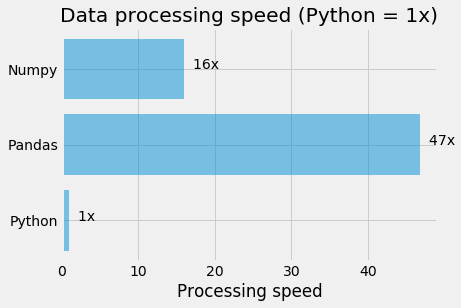

In [17]:
plt.style.use('fivethirtyeight')
objects = ('Python', 'Pandas', 'Numpy')
y_rng = np.arange(len(objects))
performance = [python_vs_python,pandas_vs_python,numpy_vs_python]
plt.barh(y_rng, performance, align='center', alpha=0.5)
plt.yticks(y_rng, objects)
plt.xlabel('Processing speed')
plt.title('Data processing speed (Python = 1x)')
for a,b in zip(performance, y_rng):
    plt.text(a, b, "  "+str(round(a))+"x")
plt.show()